In [1]:
!pip install catboost

    100% |████████████████████████████████| 55.5MB 625kB/s 
  [enum]
You must restart the runtime in order to use newly installed versions.


In [0]:
# The essentials
import pandas as pd
import numpy as np

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Progress bars
from tqdm import tqdm

# Access our Google Drive
from google.colab import drive

# Gradient Boosting
from catboost import CatBoostRegressor

from collections import defaultdict

In [3]:
drive.mount('/content/drive', force_remount=True)
!ls "/content/drive/My Drive/Rinse Over Run"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
20178.png
20451.png
20899.png
22112.png
22369.png
22414.png
22487.png
23011.png
23142.png
23599.png
23872.png
24804.png
24845.png
24872.png
25129.png
25908.png
25983.png
26270.png
27115.png
27243.png
27346.png
27366.png
27418.png
27508.png
all_train_preds_per_phase.p
baseline_features_with_preds_per_phase.csv
baseline_model_per_nunique_phases.csv
dtw_distances_3.p
more_features_with_preds_per_phase.csv
predictions_machine_405.csv
test_features_14.csv
test_feat

In [4]:
train_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_values.csv', index_col=0, parse_dates=['timestamp'])
test_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_values.csv', index_col=0, parse_dates=['timestamp'])
label_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_labels.csv', index_col='process_id')

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
# variables we'll use to create our time series features
ts_cols = [
    'process_id',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
]

# variables for binary time series features
bin_cols = [
    'supply_pump',
    'supply_pre_rinse',
    'supply_caustic',
    'return_caustic',
    'supply_acid',
    'return_acid',
    'supply_clean_water',
    'return_recovery_water',
    'return_drain',
    'object_low_level'
]

# phases, ordered from earliest to latest
phases = ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid']

In [0]:
def encode_categorical(df):
    # Currently just copy-pasted from http://drivendata.co/blog/rinse-over-run-benchmark/
    
    # select process_id and pipeline
    meta = df[['process_id', 'pipeline']].drop_duplicates().set_index('process_id') 
    
    # convert categorical pipeline data to dummy variables
    meta = pd.get_dummies(meta)
    
    # pipeline L12 not in test data (so useless feature)
    if 'pipeline_L12' in meta:
        meta = meta.drop('pipeline_L12', axis=1)
    
    # calculate number of phases for each process_object
    meta['num_phases'] = df.groupby('process_id')['phase'].apply(lambda x: x.nunique())
    
    return meta

def percentile_25(x):
  return np.percentile(x, 0.25)

def percentile_75(x):
  return np.percentile(x, 0.75)
  
def encode_real_timeseries(df):   
    ts_df = df[ts_cols].set_index('process_id')
    
    # create features: count, min, max, mean, standard deviation
    ts_features = ts_df.groupby('process_id').agg(['min', 'max', 'mean', 'std', 
                                                   'count', 'median', 'sum', 
                                                   'mad', percentile_25,
                                                   percentile_75])
    
    # Now we will get the mean + variance value of the last K measurements for each phase
    all_vals_per_phase = []
    K = 5
    col_names = ['process_id'] 
    for phase in phases:
        for col in ts_cols:
            col_names.extend(['mean_{}_{}_{}'.format(col, K, phase), 
                              'std_{}_{}_{}'.format(col, K, phase)])
    for process in tqdm(ts_features.index, total=len(ts_features)):
        vals_per_phase = [process]
        process_filtered_df = df[df['process_id'] == process]
        for phase in phases:
            filtered_df = process_filtered_df[process_filtered_df['phase'] == phase].tail(K)
            for col in ts_cols:
                vals_per_phase.extend([filtered_df[col].mean(), filtered_df[col].std()])
                
        all_vals_per_phase.append(vals_per_phase)
    values_df = pd.DataFrame(all_vals_per_phase, columns=col_names)
    values_df = values_df.set_index('process_id')
    
    ts_features = ts_features.merge(values_df, left_index=True, right_index=True)
    
    return ts_features

def encode_binary_timeseries(df):
    ts_df = df[ts_cols].set_index('process_id')
            
    # create features: count, min, max, mean, standard deviation
    ts_features = ts_df.groupby('process_id').agg(['mean', 'std', 'count', 'sum', 'mad'])
    
    # TODO: Count fraction of True in each phase
    feature_vectors = []
    col_names = ['process_id'] 
    for phase in phases:
        for col in bin_cols:
            col_names.append('fraction_{}_{}'.format(col, phase))
            
    # Get fraction of True values for each binary timeseries
    for process in tqdm(set(df['process_id']), total=len(set(df['process_id']))):
        vector = [process]
        process_filtered_df = df[df['process_id'] == process]
        for phase in phases:
            filtered_df = process_filtered_df[process_filtered_df['phase'] == phase]
            for col in bin_cols:
                if len(filtered_df):
                    vector.append(sum(filtered_df[col]) / len(filtered_df))
                else:
                    vector.append(np.NaN)
                
        feature_vectors.append(vector)
                
    feature_df = pd.DataFrame(feature_vectors, columns=col_names)
    feature_df = feature_df.set_index('process_id')
    
    feature_df = feature_df.merge(ts_features, left_index=True, right_index=True)
    
    return feature_df

def create_feature_matrix(df):
    metadata = encode_categorical(df)
    time_series = encode_real_timeseries(df)
    binary_features = encode_binary_timeseries(df)
    
    # join metadata and time series features into a single dataframe
    feature_matrix = metadata
    feature_matrix = feature_matrix.merge(time_series, left_index=True, right_index=True)
    feature_matrix = feature_matrix.merge(binary_features, left_index=True, right_index=True)
    
    return feature_matrix

In [0]:
process_comb = 15
test_features_index = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_features_{}.csv'.format(process_comb), index_col=['process_id']).index
train_features_index = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_features_adv_{}.csv'.format(process_comb), index_col=['process_id']).index
val_features_index = pd.read_csv('/content/drive/My Drive/Rinse Over Run/val_features_adv_{}.csv'.format(process_comb), index_col=['process_id']).index

In [9]:
train_df_no_final = train_df[train_df['phase'] != 'final_rinse']

X_train = create_feature_matrix(train_df_no_final[train_df_no_final['process_id'].isin(train_features_index)])
X_val = create_feature_matrix(train_df_no_final[train_df_no_final['process_id'].isin(val_features_index)])
X_test = create_feature_matrix(test_df[test_df['process_id'].isin(test_features_index)])

100%|██████████| 3354/3354 [01:15<00:00, 44.70it/s]
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:558: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
100%|██████████| 3354/3354 [00:41<00:00, 80.03it/s]
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
100%|██████████| 671/671 [00:05<00:00, 114.77it/s]


In [0]:
# Getting the duration of the processes
train_df_final = train_df[train_df['phase'] == 'final_rinse']

durations = []
for ix in X_train.index:
  durations.append(len(train_df_final[train_df_final['process_id'] == ix]))
y_train = pd.Series(data=durations, index=X_train.index)

durations = []
for ix in X_val.index:
  durations.append(len(train_df_final[train_df_final['process_id'] == ix]))
y_val = pd.Series(data=durations, index=X_val.index)

In [0]:
def custom_mape(approxes, targets):
    return np.mean(np.abs(np.subtract(approxes, targets)) / np.maximum(np.abs(targets), 290000))

class MAPEMetric(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, targets, weight):
        return custom_mape(approxes, targets), len(targets)

In [36]:
cat = CatBoostRegressor(iterations=100000, od_type='Iter', od_wait=100, learning_rate=0.1,
                        loss_function='MAE', eval_metric='MAE')
cat.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=50)

0:	learn: 307.4758149	test: 322.3792890	best: 322.3792890 (0)	total: 437ms	remaining: 12h 9m 8s
50:	learn: 305.0425874	test: 319.9758007	best: 319.9758007 (50)	total: 22.5s	remaining: 12h 14m 33s
100:	learn: 302.5975077	test: 317.5469329	best: 317.5469329 (100)	total: 44.2s	remaining: 12h 8m 56s
150:	learn: 300.1111407	test: 315.0626473	best: 315.0626473 (150)	total: 56.3s	remaining: 10h 20m 57s
200:	learn: 297.6142693	test: 312.5676332	best: 312.5676332 (200)	total: 58.4s	remaining: 8h 2m 51s
250:	learn: 295.1173701	test: 310.0718497	best: 310.0718497 (250)	total: 1m	remaining: 6h 39m 31s
300:	learn: 292.6203971	test: 307.5763776	best: 307.5763776 (300)	total: 1m 2s	remaining: 5h 43m 50s
350:	learn: 290.1235677	test: 305.0812001	best: 305.0812001 (350)	total: 1m 4s	remaining: 5h 4m 4s
400:	learn: 287.6265482	test: 302.5855581	best: 302.5855581 (400)	total: 1m 6s	remaining: 4h 34m 6s
450:	learn: 285.1296791	test: 300.0884999	best: 300.0884999 (450)	total: 1m 8s	remaining: 4h 10m 45s
50

KeyboardInterrupt: ignored

In [22]:
def mae(real, preds):
  return np.mean(real - preds)

mae(cat.predict(X_val), y_val)

7.393971068141912

In [24]:
min(y_val)

142

In [0]:
# Getting the duration of the processes
train_df_final = train_df[train_df['phase'] == 'final_rinse']

durations = []
for ix in X_train.index:
  durations.append(sum(train_df_final[train_df_final['process_id'] == ix]['target_time_period'].astype(float).values == 0))
y_train = pd.Series(data=durations, index=X_train.index)

durations = []
for ix in X_val.index:
  durations.append(sum(train_df_final[train_df_final['process_id'] == ix]['target_time_period'].astype(float).values == 0))
y_val = pd.Series(data=durations, index=X_val.index)

In [32]:
cat = CatBoostRegressor(iterations=100000, od_type='Iter', od_wait=100, depth=4,
                        loss_function='MAE', eval_metric='MAE')
cat.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=50)

0:	learn: 145.1092136	test: 159.9125950	best: 159.9125950 (0)	total: 85.6ms	remaining: 2h 22m 35s
50:	learn: 144.3679876	test: 159.1721241	best: 159.1721241 (50)	total: 5.59s	remaining: 3h 2m 43s
100:	learn: 143.6264990	test: 158.4321925	best: 158.4321925 (100)	total: 12.2s	remaining: 3h 20m 27s
150:	learn: 142.8846837	test: 157.6913293	best: 157.6913293 (150)	total: 18.8s	remaining: 3h 26m 51s
200:	learn: 142.1433727	test: 156.9507735	best: 156.9507735 (200)	total: 25.3s	remaining: 3h 29m 37s
250:	learn: 141.4018457	test: 156.2124914	best: 156.2124914 (250)	total: 31.8s	remaining: 3h 30m 50s
300:	learn: 140.6602535	test: 155.4716782	best: 155.4716782 (300)	total: 38.4s	remaining: 3h 32m 2s
350:	learn: 139.9173838	test: 154.7308595	best: 154.7308595 (350)	total: 45s	remaining: 3h 32m 52s
400:	learn: 139.1723720	test: 153.9865292	best: 153.9865292 (400)	total: 51.5s	remaining: 3h 33m 3s
450:	learn: 138.4251069	test: 153.2402924	best: 153.2402924 (450)	total: 56.9s	remaining: 3h 29m 17s


KeyboardInterrupt: ignored

In [30]:
def mae(real, preds):
  return np.mean(real - preds)

mae(cat.predict(X_val), y_val)

0.421101730600333

In [31]:
list(zip(cat.predict(X_val), y_val))

[(44.18852317941821, 37),
 (14.659159021040242, 45),
 (80.2481141345426, 73),
 (106.40919575091637, 118),
 (90.85226856965761, 111),
 (49.16709114944241, 36),
 (121.63627896017069, 133),
 (130.81567260869366, 124),
 (144.43153257252607, 143),
 (121.78183138161513, 111),
 (432.33304498964606, 404),
 (99.42420379674671, 102),
 (136.76833213658074, 150),
 (101.25133087379609, 115),
 (260.172756269399, 255),
 (46.04670866824798, 41),
 (121.26322564232849, 109),
 (137.02725750512286, 135),
 (121.83428443920589, 122),
 (86.34174804798893, 102),
 (86.14852977817077, 76),
 (89.7578218957238, 90),
 (307.9348096638808, 300),
 (106.07080756038413, 97),
 (223.94223769014357, 222),
 (411.5805313377793, 420),
 (45.03924668844275, 30),
 (90.53808100694508, 94),
 (168.61866284550752, 180),
 (147.2436080984899, 137),
 (348.8849876281756, 283),
 (539.3365676331855, 493),
 (139.7249565126548, 153),
 (98.12515999933987, 89),
 (119.55732432868703, 86),
 (167.7902975064755, 174),
 (99.64813648638572, 89),
 

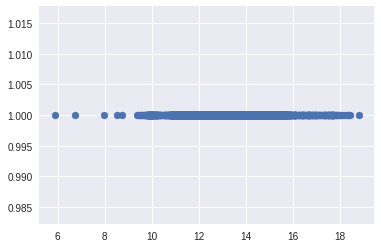

In [43]:
plt.scatter(np.log(label_df.values), [1]*len(label_df))